<a href="https://colab.research.google.com/github/aydinmyilmaz/Transformers-Tutorials/blob/master/HF_fine_tune_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install transformers


In [2]:
!pip install -q datasets

     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 212 kB 43.7 MB/s 
     |████████████████████████████████| 1.1 MB 40.9 MB/s 
     |████████████████████████████████| 136 kB 45.3 MB/s 
     |████████████████████████████████| 127 kB 46.9 MB/s 
     |████████████████████████████████| 144 kB 48.4 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 271 kB 9.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
## 

## 0. Datasets Overview

In [4]:
from datasets import list_datasets

In [5]:
all_datasets = list_datasets()

In [6]:
all_datasets[0:10]

['acronym_identification',
 'ade_corpus_v2',
 'adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus',
 'ag_news',
 'ai2_arc',
 'air_dialogue',
 'ajgt_twitter_ar',
 'allegro_reviews']

In [7]:
len(all_datasets)

3902

In [8]:
from datasets import load_dataset
emotions = load_dataset("emotion")

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [10]:
emotions["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [12]:
import pandas as pd
df_sample = pd.DataFrame(list(zip(emotions["train"]["text"][0:10], emotions["train"]["label"][0:10])), columns=['text','label'])
df_sample

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [13]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [14]:
len(train_ds)

16000

In [15]:
train_ds[0]

{'label': 0, 'text': 'i didnt feel humiliated'}

In [16]:
train_ds.column_names

['text', 'label']

In [17]:
train_ds.features

{'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'text': Value(dtype='string', id=None)}

## 1. From Datasets to DataFrames

In [18]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [19]:
def label_int2str(row):
  return emotions['train'].features['label'].int2str(row)

df['label_name'] =df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


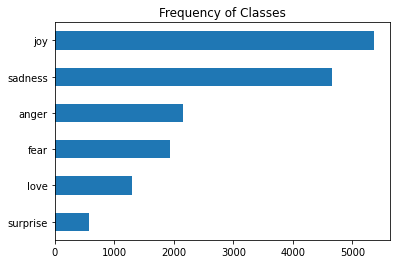

In [20]:
import matplotlib.pyplot as plt
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


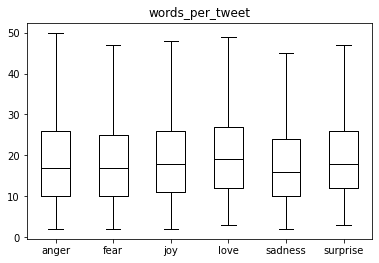

In [21]:
df['words_per_tweet'] = df['text'].str.split().apply(len)
df.boxplot("words_per_tweet", by="label_name", grid=False,
           showfliers=False, color='black')
plt.suptitle('')
plt.xlabel("")
plt.show()

In [22]:
emotions.reset_format()

# 3. Tokenization

In [24]:
from transformers import AutoTokenizer, DistilBertTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [26]:
encoded_text = tokenizer("Tokenizing a text is a core task in NLP")
print(encoded_text)

{'input_ids': [101, 19204, 6026, 1037, 3793, 2003, 1037, 4563, 4708, 1999, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [30]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'a', 'text', 'is', 'a', 'core', 'task', 'in', 'nl', '##p', '[SEP]']


In [31]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing a text is a core task in nlp [SEP]


In [32]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

# 4. Tokenizing whole dataset

In [34]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [45]:
emotions['train']['text'][1:2]

['i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake']

In [44]:
print(tokenize(emotions['train'][1:2]).keys())

dict_keys(['input_ids', 'attention_mask'])


In [40]:
print(tokenize(emotions['train'][1:2])['input_ids'])

[[101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]]


In [53]:
print(tokenize(emotions['train'][0:2])['attention_mask'])

[[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [46]:
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [54]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [55]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [57]:
#emotions_encoded['train'][0]

# 5. Training a Text Classifier

## 5.1 Using Transformers as Feature Extractors

In [60]:
import torch
from transformers import AutoModel

AutoModel class converts the token encodings to embeddings, then feeds them through the encoder stack to return the hidden states

In [61]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Extracting the last hidden states

In [73]:
text = ['this is a test',"this is also another test"]
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([2, 7])


In [74]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask'])

In [75]:
inputs['input_ids']

tensor([[ 101, 2023, 2003, 1037, 3231,  102,    0],
        [ 101, 2023, 2003, 2036, 2178, 3231,  102]])

In [76]:
inputs['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1]])

Next step to place tensor of encodings on to the same deevice as the model

In [86]:
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         ...,
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619],
         [ 0.0352, -0.3883,  0.0161,  ...,  0.0221,  0.0190,  0.4101]],

        [[-0.1180, -0.1797,  0.0433,  ..., -0.0840,  0.1692,  0.4245],
         [-0.2321, -0.5506, -0.1626,  ..., -0.0848,  0.5411,  0.2210],
         [-0.4013, -0.4071,  0.0957,  ..., -0.0099,  0.2094,  0.7743],
         ...,
         [-0.3098, -0.4207,  0.0505,  ...,  0.1818,  0.4265,  0.3154],
         [ 0.1886, -0.4392, -0.3297,  ..., -0.2462,  0.0583, -0.3996],
         [ 1.0088, -0.0087, -0.4521,  ...,  0.1389, -0.5730, -0.2557]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [83]:
print(outputs[0][1])

tensor([[-0.1180, -0.1797,  0.0433,  ..., -0.0840,  0.1692,  0.4245],
        [-0.2321, -0.5506, -0.1626,  ..., -0.0848,  0.5411,  0.2210],
        [-0.4013, -0.4071,  0.0957,  ..., -0.0099,  0.2094,  0.7743],
        ...,
        [-0.3098, -0.4207,  0.0505,  ...,  0.1818,  0.4265,  0.3154],
        [ 0.1886, -0.4392, -0.3297,  ..., -0.2462,  0.0583, -0.3996],
        [ 1.0088, -0.0087, -0.4521,  ...,  0.1389, -0.5730, -0.2557]],
       device='cuda:0')


In [85]:
print(outputs[0].shape)

torch.Size([2, 7, 768])


In [87]:
print(outputs.last_hidden_state.size())

torch.Size([2, 7, 768])


In [105]:
import numpy
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  #return vector for [CLS] token
  return {"hidden_state":last_hidden_state[:,0].cpu().numpy()}


In [103]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [106]:
emotions_encoded.set_format("torch",
                            columns = ["input_ids", "attention_mask", "label"])

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [107]:
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

- Generating a feature matrix

In [108]:
import numpy as np

In [122]:
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])

y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

X_train.shape, X_valid.shape



((16000, 768), (2000, 768))

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)


In [123]:
lr_clf.score(X_valid, y_valid)

0.633